In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from pysandag.database import get_connection_string
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [2]:
db_connection_string = get_connection_string('..\data\config.yml', 'mssql_db')
mssql_engine = create_engine(db_connection_string)

## Get subregional simulation output

In [3]:
# get max run id from urbansim
run_id_sql = '''
SELECT max(run_id)
  FROM [urbansim].[urbansim].[urbansim_lite_output]
'''
run_id_df = pd.read_sql(run_id_sql, mssql_engine)
run_id = int(run_id_df.values)
print("\n   Max run id : {:,}".format(run_id))

hs_change_sql = '''
    SELECT o.parcel_id, j.name,  p.cap_jurisdiction_id, p.jurisdiction_id, p.mgra_id, p.luz_id,
    unit_change as hs_change, source, year_simulation
      FROM urbansim.urbansim.urbansim_lite_output o 
      JOIN urbansim.urbansim.parcel p on p.parcel_id = o.parcel_id
      JOIN urbansim.ref.jurisdiction j on p.cap_jurisdiction_id = j.jurisdiction_id
     WHERE run_id =  %s
  ORDER BY j.name,p.jurisdiction_id, year_simulation'''
hs_change_sql = hs_change_sql % run_id
hs = pd.read_sql(hs_change_sql,mssql_engine)
print("\n   Units added: {:,}".format(int(hs.hs_change.sum())))


   Max run id : 3

   Units added: 361,715


## Get SR13

In [30]:
sr13_sql = '''
select x.mgra, hs, increment, city, cpa, x.luz as luz_id
from [regional_forecast].[sr13_final].[mgrabase] x
join [regional_forecast].[sr13_final].[mgra13] y
on x.mgra = y.mgra
where scenario = 0'''
sr13_df = pd.read_sql(sr13_sql, mssql_engine)

## QC check output against jurisdiction feedback confluence pg (since all capacity used)

https://sandag.atlassian.net/wiki/spaces/LUM/pages/101679105/Jurisdictional+Feedback

In [5]:
jur_cap_df = pd.DataFrame({'units_change': hs.groupby(['cap_jurisdiction_id']).hs_change.sum()}).reset_index()
jur_cap_df.set_index('cap_jurisdiction_id',inplace=True)
jur_cap_df

,units_change
cap_jurisdiction_id,
1,6425
2,27215
3,229
4,53
5,3283
6,2460
7,12024
8,3569
9,9307


## Get total dwelling units in the region and sum by jurisdiction and cpa

#### note using cap jurisdiction id

In [6]:
du_sql = '''
    SELECT parcel_id, mgra_id, luz_id, p.jurisdiction_id, cap_jurisdiction_id, j.name, du, capacity 
        FROM urbansim.parcel p
        LEFT JOIN urbansim.ref.jurisdiction j on p.cap_jurisdiction_id = j.jurisdiction_id
        WHERE du > 0'''
du = pd.read_sql(du_sql,mssql_engine)
du.cap_jurisdiction_id.fillna(du.jurisdiction_id,inplace=True) # where there is no cap jurisdiction id 
print("\n   Dwelling Units: {:,}".format(int(du.du.sum())))


   Dwelling Units: 1,183,211


## Get CPAs for city and county

#### complete list for plotting, i.e. plot zero for those with no change

In [7]:
xref_geography_sql = '''
    SELECT mgra_13, cocpa_2016, cicpa_13
      FROM data_cafe.ref.vi_xref_geography_mgra_13
      where jurisdiction_2016 IN (14,19)'''
xref_geography_df = pd.read_sql(xref_geography_sql, mssql_engine)
# remove mgras without a CPA (mgra_13 = 7259)
xref_geography_df = xref_geography_df.loc[~((xref_geography_df.cocpa_2016.isnull()) & (xref_geography_df.cicpa_13.isnull()))].copy()
len(xref_geography_df)
print("\n Note: {:,} MGRAs in City and County CPAs (of 23,002 MGRAs)".format(len(xref_geography_df)))


 Note: 14,407 MGRAs in City and County CPAs (of 23,002 MGRAs)


#### for jurisdiction 19 use cocpa_2016 and for jurisdiction 14 use cicpa_13

In [8]:
# simulation output
units = pd.merge(hs,xref_geography_df,left_on='mgra_id',right_on='mgra_13',how = 'outer')
units['jcid'] = units['cap_jurisdiction_id']
units.loc[units.cap_jurisdiction_id == 19,'jcid'] = units['cocpa_2016']
units.loc[units.cap_jurisdiction_id == 14,'jcid'] = units['cicpa_13']
# dwelling units
dus = pd.merge(du,xref_geography_df,left_on='mgra_id',right_on='mgra_13',how = 'outer')
dus['jcid'] = dus['cap_jurisdiction_id']
dus.loc[dus.cap_jurisdiction_id == 19,'jcid'] = dus['cocpa_2016']
dus.loc[dus.cap_jurisdiction_id == 14,'jcid'] = dus['cicpa_13']

In [9]:
len(xref_geography_df)

14407

In [10]:
len(hs)

51388

In [11]:
len(units)

59037

### In cases where there was no unit change for an MGRA, fill in with zero values

#### note: joined on mgra for geography

In [12]:
# CPAs = units.jcid.unique().tolist() # CPAS in df
# units.loc[(units.mgra_id.isnull()) & (~units.cicpa_13.isin(CPAs))]

In [13]:
units.loc[units['hs_change'].isnull()].head(2)

,parcel_id,name,cap_jurisdiction_id,jurisdiction_id,mgra_id,luz_id,hs_change,source,year_simulation,mgra_13,cocpa_2016,cicpa_13,jcid
51388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19897.0,1909.0,NaN,NaN
51389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1566.0,NaN,1444.0,NaN


In [14]:
units.loc[units.jcid.isnull(),'jcid'] = units['cicpa_13']
units.loc[units.jcid.isnull(),'jcid'] = units['cocpa_2016']
units.fillna(0, inplace=True)
dus.loc[dus.jcid.isnull(),'jcid'] = dus['cicpa_13']
dus.loc[dus.jcid.isnull(),'jcid'] = dus['cocpa_2016']
dus.fillna(0, inplace=True)

In [15]:
units.loc[units['hs_change']==0].head(2)

,parcel_id,name,cap_jurisdiction_id,jurisdiction_id,mgra_id,luz_id,hs_change,source,year_simulation,mgra_13,cocpa_2016,cicpa_13,jcid
51388,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,19897.0,1909.0,0.0,1909.0
51389,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,1566.0,0.0,1444.0,1444.0


### In cases where a parcel has no CPA but in jurisdiction 14 or 19, find nearest CPA for plotting

In [16]:
units.loc[units['jcid']==0]

,parcel_id,name,cap_jurisdiction_id,jurisdiction_id,mgra_id,luz_id,hs_change,source,year_simulation,mgra_13,cocpa_2016,cicpa_13,jcid
44197,5038426.0,Unincorporated,19.0,19.0,19415.0,18.0,5.0,subregional_control,2026.0,0.0,0.0,0.0,0.0


In [17]:
dus.loc[dus['jcid']==0]

,parcel_id,mgra_id,luz_id,jurisdiction_id,cap_jurisdiction_id,name,du,capacity,mgra_13,cocpa_2016,cicpa_13,jcid
163536,73610.0,18831.0,167.0,19.0,19.0,Unincorporated,1.0,0.0,0.0,0.0,0.0,0.0
493558,689257.0,11514.0,37.0,13.0,19.0,Unincorporated,2.0,0.0,0.0,0.0,0.0,0.0
500358,723076.0,7521.0,133.0,3.0,14.0,San Diego,54.0,0.0,0.0,0.0,0.0,0.0
586450,5038426.0,19415.0,18.0,19.0,19.0,Unincorporated,1.0,5.0,0.0,0.0,0.0,0.0


## use sql query to find nearest CPA

#### set jcid to nearest CPA and change cocpa_2016 or cicpa_13 to match (for looking up name later)

In [18]:
# for plotting: change mgra 19415 to 19423 in county bc it has capacity from the county but is in San Marcos
# mgra=19415 is in Ciyt=15 San Marcos but has capacity of 5 from County so assigning it a nearby mgra
# so it will now be CPA 1909 (for the purposes of plotting)
units.loc[units.mgra_id==19415,'jcid'] = 1909
units.loc[units.mgra_id==19415,'cocpa_2016'] = 1909
# unit.loc[units.mgra_id == 19415,'mgra_id'] = 19423

In [19]:
dus.loc[dus.mgra_id==18831.0,'jcid'] = 1909
dus.loc[dus.mgra_id==18831.0,'cocpa_2016'] = 1909
dus.loc[dus.mgra_id==11514.0,'jcid'] = 1914
dus.loc[dus.mgra_id==11514.0,'cocpa_2016'] = 1914
dus.loc[dus.mgra_id==7521.0,'jcid'] = 3 # North Island not jurisdiction 14?
dus.loc[dus.mgra_id==19415.0,'jcid'] = 1909
dus.loc[dus.mgra_id==19415.0,'cocpa_2016'] = 1909

#### convert jcid column that has jurisdiction id and CPAs to integer (only possible if no null values in column)

In [20]:
units['jcid'] = units['jcid'].astype(int) 
dus['jcid'] = dus['jcid'].astype(int)

### Add cpa name

In [21]:
cocpa_names_sql = '''
    SELECT zone as cocpa_id, name as cocpa
    FROM data_cafe.ref.geography_zone WHERE geography_type_id = 20'''
cocpa_names = pd.read_sql(cocpa_names_sql, mssql_engine)
cicpa_names_sql = '''
    SELECT zone as cicpa_id, name as cicpa
    FROM data_cafe.ref.geography_zone WHERE geography_type_id = 15'''
cicpa_names = pd.read_sql(cicpa_names_sql, mssql_engine)
luz_names_sql = '''
    SELECT zone as luz_id, name as luz
    FROM data_cafe.ref.geography_zone WHERE geography_type_id = 64'''
luz_names = pd.read_sql(luz_names_sql, mssql_engine)     

In [22]:
units = pd.merge(units,cocpa_names,left_on='cocpa_2016',right_on='cocpa_id',how = 'left')
units = pd.merge(units,cicpa_names,left_on='cicpa_13',right_on='cicpa_id',how = 'left')

In [23]:
units['jcname'] = units['name']
units.loc[units.jcid>=1900,'jcname'] = units['cocpa']
units.loc[(units.jcid>=1400) & (units.jcid<1900),'jcname'] = units['cicpa']

In [24]:
# check that there are no nulls values (should equal 103)
len(units.jcname.unique())

103

#### check results again to match jurisdiction feedback page

In [25]:
change_df = pd.DataFrame({'chg': units.groupby(['jcid','jcname']).
                               hs_change.sum()}).reset_index()
change_df['jcid'] =change_df['jcid'].astype(int)
change_df.set_index('jcid',inplace=True)
# change_df

## Get CPAs for city and county for sr13

In [31]:
jurisdictions_names_sql = '''
    SELECT zone as jurisdiction_id, name as jurisdiction
    FROM data_cafe.ref.geography_zone WHERE geography_type_id = 150'''
jur_name_df = pd.read_sql(jurisdictions_names_sql, mssql_engine)
cocpa_names_sql = '''
    SELECT zone as cocpa_id, name as cocpa
    FROM data_cafe.ref.geography_zone WHERE geography_type_id = 20'''
cocpa_names = pd.read_sql(cocpa_names_sql, mssql_engine)
cicpa_names_sql = '''
    SELECT zone as cicpa_id, name as cicpa
    FROM data_cafe.ref.geography_zone WHERE geography_type_id = 15'''
cicpa_names = pd.read_sql(cicpa_names_sql, mssql_engine)
luz_names_sql = '''
    SELECT zone as luz_id, name as luz
    FROM data_cafe.ref.geography_zone WHERE geography_type_id = 64'''
luz_names = pd.read_sql(luz_names_sql, mssql_engine)     

In [32]:
sr13_df = pd.merge(sr13_df,jur_name_df[['jurisdiction_id','jurisdiction']],left_on='city',right_on='jurisdiction_id')
sr13_df = pd.merge(sr13_df,cocpa_names[['cocpa_id','cocpa']],left_on='cpa',right_on='cocpa_id', how = 'outer')
sr13_df = pd.merge(sr13_df,cicpa_names[['cicpa_id','cicpa']],left_on='cpa',right_on='cicpa_id',how = 'outer')
sr13_df = pd.merge(sr13_df,luz_names[['luz_id','luz']],left_on='luz_id',right_on='luz_id')
sr13_df['jur_or_cpa_name'] = sr13_df['cocpa']
sr13_df['jur_or_cpa_name'].fillna(sr13_df['cicpa'],inplace=True)
sr13_df['jur_or_cpa_name'].fillna(sr13_df['jurisdiction'],inplace=True)
sr13_df['jur_or_cpa_id'] = sr13_df['cocpa_id']
sr13_df['jur_or_cpa_id'].fillna(sr13_df['cicpa_id'],inplace=True)
sr13_df['jur_or_cpa_id'].fillna(sr13_df['jurisdiction_id'],inplace=True)
sr13_df['jur_or_cpa_id'] = sr13_df['jur_or_cpa_id'].astype(int)
sr13_df.drop(['jurisdiction_id', 'cocpa_id', 'cicpa_id', 'cocpa', 'cicpa'], axis=1,inplace=True)
# sr13_df.to_csv('test.csv')

## sum dwelling units by jursidictions and CPAs (n=103)

In [33]:
du_sr14_geo_df = pd.DataFrame(dus.groupby(['jcid']).\
                            du.sum()).reset_index()
du_sr14_geo_df.sort_values(by='jcid',inplace=True)
du_sr14_geo_df.set_index('jcid',inplace=True)
du_sr14_geo_df['du'] = du_sr14_geo_df['du'].astype(int)
print("\n Total residential dwelling units after groupby: {:,}".format(int(du_sr14_geo_df.du.sum())))
print("\n Total number of jurisdictions and cpas: {:,}\n".format(len(du_sr14_geo_df.index.unique())))


 Total residential dwelling units after groupby: 1,183,211

 Total number of jurisdictions and cpas: 103



## sum hs change in simulation by jursidictions and CPAs (n=103)

In [34]:
sr14_geo_df = pd.DataFrame({'hs_sum': units.groupby(['jcid','jcname','year_simulation']).\
                            hs_change.sum()}).reset_index()
sr14_geo_df.rename(columns = {'jcname':'geo'},inplace=True)
# sr14_geo_df.rename(columns = {'year_simulation':'increment'},inplace=True)
sr14_geo_df.sort_values(by='jcid',inplace=True)
sr14_geo_df.set_index('jcid',inplace=True)
sr14_geo_df['hs_sum'] = sr14_geo_df['hs_sum'].astype(int)
sr14_geo_df['year_simulation'] = sr14_geo_df['year_simulation'].astype(int)
print("\n Total housing unit change after groupby: {:,}".format(int(sr14_geo_df.hs_sum.sum())))
print("\n Total number of jurisdictions and cpas: {:,}\n".format(len(sr14_geo_df.index.unique())))


 Total housing unit change after groupby: 361,715

 Total number of jurisdictions and cpas: 103



## Fill in "0" for units for "missing" simulation years (for plotting) (e.g. Del Mar)

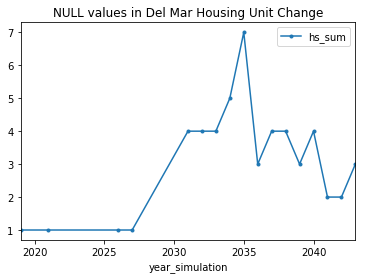

In [35]:
# Del Mar example
del_mar_before = sr14_geo_df.loc[4].sort_values(by='year_simulation')
# del_mar_before.head()
del_mar_before.plot(x='year_simulation',y='hs_sum',style='.-',title='NULL values in Del Mar Housing Unit Change')

In [36]:
idx = range(2017,2051)
sr14_geo_df.set_index(['geo','year_simulation'],append=True,inplace=True)
sr14_geo_df = sr14_geo_df.unstack(['jcid','geo'])
sr14_geo_df = sr14_geo_df.reindex(idx, fill_value=0)
sr14_geo_df.fillna(0,inplace=True)
sr14_geo_df = sr14_geo_df.stack(['jcid','geo'])
sr14_geo_df.reset_index(inplace=True)
sr14_geo_df.set_index('jcid',inplace=True)

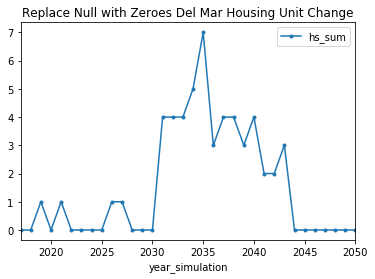

In [37]:
del_mar_after = sr14_geo_df.loc[4].sort_values(by='year_simulation')
del_mar_after.plot(x='year_simulation',y='hs_sum',style='.-',title='Replace Null with Zeroes Del Mar Housing Unit Change')

In [38]:
len(sr14_geo_df.geo.unique())

103

In [39]:
len(du_sr14_geo_df)

103

In [40]:
len(sr14_geo_df.year_simulation.unique())

34

In [41]:
len(sr14_geo_df.year_simulation.unique()) * len(sr14_geo_df.geo.unique())

3502

In [42]:
len(sr14_geo_df)

3502

## Sum units from output of simulation over five year increments

In [43]:
bins = range(2015,2055,5)
names = [str(x) for x in range(2020,2055,5)]
sr14_geo_df['increment'] = pd.cut(sr14_geo_df.year_simulation, bins, labels=names)

In [44]:
sr14_increment = pd.DataFrame({'hs_increment': sr14_geo_df.
                                            groupby(["increment","jcid","geo"]).
                                 hs_sum.sum()}).reset_index()
# sr14_increment.set_index('jcid',inplace=True)

In [45]:
sr14_increment.head()

,increment,jcid,geo,hs_increment
0,2020,1,Carlsbad,2030.0
1,2020,2,Chula Vista,13735.0
2,2020,3,Coronado,28.0
3,2020,4,Del Mar,1.0
4,2020,5,El Cajon,280.0


## Cumulative sum units added by increment

In [46]:
sr14_increment['hs_cumulative'] = sr14_increment.groupby(['geo'])['hs_increment'].apply(lambda x: x.cumsum())
sr14_increment.set_index('jcid',inplace=True)

In [47]:
sr14_increment.loc[sr14_increment.geo=='Carlsbad']

,increment,geo,hs_increment,hs_cumulative
jcid,,,,
1,2020,Carlsbad,2030.0,2030.0
1,2025,Carlsbad,1378.0,3408.0
1,2030,Carlsbad,1625.0,5033.0
1,2035,Carlsbad,1164.0,6197.0
1,2040,Carlsbad,228.0,6425.0
1,2045,Carlsbad,0.0,6425.0
1,2050,Carlsbad,0.0,6425.0


## Add increment 2016 with units added equal to zero for baseline du (for plotting)

In [48]:
start_year = sr14_geo_df.loc[sr14_geo_df.year_simulation==2017].copy()

In [49]:
len(start_year)

103

In [50]:
start_year['increment'] = '2016'
start_year['hs_cumulative'] = 0
start_year['year_simulation'] = 'baseline'

In [51]:
sr14_increment = pd.concat([sr14_increment,start_year])

## Join simulation output with existing dwelling units

In [52]:
len(sr14_increment)

824

In [53]:
len(du_sr14_geo_df)

103

In [54]:
sr14 = sr14_increment.join(du_sr14_geo_df)

In [55]:
sr14['hs'] = sr14['hs_cumulative'] + sr14['du']

In [56]:
sr14.head()

,geo,hs_cumulative,hs_increment,hs_sum,increment,year_simulation,du,hs
jcid,,,,,,,,
1,Carlsbad,2030.0,2030.0,NaN,2020,NaN,46021,48051.0
1,Carlsbad,3408.0,1378.0,NaN,2025,NaN,46021,49429.0
1,Carlsbad,5033.0,1625.0,NaN,2030,NaN,46021,51054.0
1,Carlsbad,6197.0,1164.0,NaN,2035,NaN,46021,52218.0
1,Carlsbad,6425.0,228.0,NaN,2040,NaN,46021,52446.0


## SR13 aggregrate

####  mgra level housing to cpa and jurisdiction and group by increment and sum

In [57]:
sr13_geo_df = pd.DataFrame({'hs_sum': sr13_df.groupby(['jur_or_cpa_name','jur_or_cpa_id','increment']).
                               hs.sum()}).reset_index()
sr13_geo_df.rename(columns = {'jur_or_cpa_name':'geo'},inplace=True)
sr13_geo_df.sort_values(by='jur_or_cpa_id',inplace=True)
sr13_geo_df.head()

,geo,jur_or_cpa_id,increment,hs_sum
71,Carlsbad,1,2050,50505
64,Carlsbad,1,2015,46358
65,Carlsbad,1,2020,48448
66,Carlsbad,1,2025,49048
67,Carlsbad,1,2030,49629


In [58]:
print("\nNum of geographies (jurisdiction plus cpa) = {:,}\n".format(int(len(sr13_geo_df.loc[sr13_geo_df.increment==2015]))))


Num of geographies (jurisdiction plus cpa) = 103



##  sr13 pivot so each jurisdiction or cpa is column and rows are increments

In [59]:
sr13_geo_df_pivot = sr13_geo_df.pivot\
(index='increment', columns='geo', values='hs_sum').\
reset_index().rename_axis(None, axis=1)
sr13_geo_df_pivot.set_index('increment',inplace=True)
sr13_geo_df_pivot

,32nd Street Naval Station,Alpine,Balboa Park,Barona,Barrio Logan,Black Mountain Ranch,Bonsall,Carlsbad,Carmel Mountain Ranch,Carmel Valley,...,Tijuana River Valley,Torrey Highlands,Torrey Hills,Torrey Pines,University,Uptown,Valle De Oro,Valley Center,Via De La Valle,Vista
increment,,,,,,,,,,,,,,,,,,,,,
2012,0,6565,14,202,1232,2591,3905,45171,5072,13487,...,16,2259,2520,3077,26412,23100,15582,6664,224,30860
2015,0,6419,14,202,1232,4843,3949,46358,5072,13520,...,16,2260,2904,3156,27403,23160,15307,6785,224,31209
2020,0,7319,14,202,1397,5126,4329,48448,5072,13707,...,16,2688,2905,3082,28495,23593,15434,7830,230,31012
2025,0,7834,14,202,1394,5126,4553,49048,5072,13730,...,16,2689,2905,3098,28650,25880,15898,8059,230,32884
2030,0,8255,14,202,2214,5126,4893,49629,5072,13737,...,16,2690,2905,3132,28802,27674,16026,8343,230,34028
2035,0,8636,14,202,2601,5126,5220,50261,5072,13738,...,16,2691,2905,3137,28855,29223,15974,8737,230,35307
2040,0,8802,14,202,2847,5126,5285,50491,5072,13748,...,16,2708,2905,3249,28941,30721,16146,8968,230,37280
2045,0,9158,14,202,3294,5126,5334,50492,5072,13752,...,16,2716,2905,3322,29042,32403,16225,9573,230,39187
2050,0,9495,14,202,3680,5130,5337,50505,5072,13768,...,16,2737,2905,3337,29053,34103,16235,9580,230,40181


##  sr14 pivot so each jurisdiction or cpa is column and rows are increments

In [61]:
sr14_geo_df_pivot = sr14.pivot\
(index='increment', columns='geo', values='hs').\
reset_index().rename_axis(None, axis=1)
sr14_geo_df_pivot.set_index('increment',inplace=True)
sr14_geo_df_pivot.fillna(0,inplace=True)
sr14_geo_df_pivot

,32nd Street Naval Station,Alpine,Balboa Park,Barona,Barrio Logan,Black Mountain Ranch,Bonsall,Carlsbad,Carmel Mountain Ranch,Carmel Valley,...,Tijuana River Valley,Torrey Highlands,Torrey Hills,Torrey Pines,University,Uptown,Valle De Oro,Valley Center,Via De La Valle,Vista
increment,,,,,,,,,,,,,,,,,,,,,
2016,0.0,6609.0,14.0,244.0,1318.0,3464.0,3943.0,46021.0,5072.0,13526.0,...,16.0,2398.0,2904.0,3079.0,26412.0,23197.0,15602.0,6683.0,224.0,31062.0
2020,0.0,6609.0,14.0,244.0,1236.0,4682.0,4041.0,48051.0,5072.0,13525.0,...,16.0,3028.0,2904.0,3079.0,27661.0,23200.0,15602.0,6760.0,224.0,32248.0
2025,0.0,7220.0,14.0,244.0,1145.0,5356.0,4620.0,49429.0,5072.0,14217.0,...,16.0,3046.0,2904.0,3096.0,28590.0,25882.0,15903.0,7272.0,230.0,34555.0
2030,0.0,8161.0,14.0,244.0,2775.0,5356.0,5478.0,51054.0,5072.0,14232.0,...,16.0,3046.0,2904.0,3159.0,28875.0,29934.0,16060.0,8399.0,230.0,35938.0
2035,0.0,8797.0,14.0,244.0,3287.0,5356.0,6022.0,52218.0,5072.0,14232.0,...,16.0,3046.0,2904.0,3165.0,28939.0,32422.0,16077.0,9563.0,230.0,37052.0
2040,0.0,9244.0,14.0,244.0,3613.0,5362.0,6181.0,52446.0,5072.0,14247.0,...,16.0,3046.0,2904.0,3316.0,29003.0,35155.0,16236.0,11000.0,230.0,39034.0
2045,0.0,10341.0,14.0,244.0,3613.0,5402.0,6221.0,52446.0,5072.0,14261.0,...,16.0,3046.0,2904.0,3337.0,29003.0,36192.0,16260.0,12756.0,230.0,39384.0
2050,0.0,10341.0,14.0,244.0,3613.0,5402.0,6221.0,52446.0,5072.0,14261.0,...,16.0,3046.0,2904.0,3337.0,29003.0,36192.0,16260.0,12756.0,230.0,39384.0


####  sr13 calculate total change by region and jurisdiction and cpa

In [62]:
total_diff = sr13_geo_df_pivot.loc[[2012,2050],:]
differences = total_diff.diff().loc[[2050]]
differences.rename(index={2050: 'total_change'},inplace=True)
totalchange = pd.DataFrame(differences.sum(axis=0))
totalchange.rename(columns={0: 'total_change'},inplace=True)
print("\nTotal Units added sr13: {:,}".format(int(totalchange.total_change.sum())))


Total Units added sr13: 326,117


In [ ]:
['Carlsbad','Chula Vista']

# plot

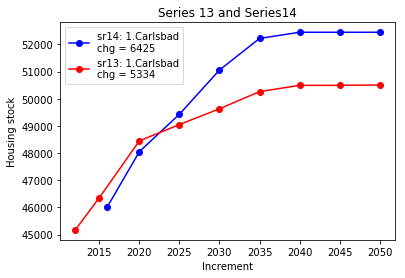

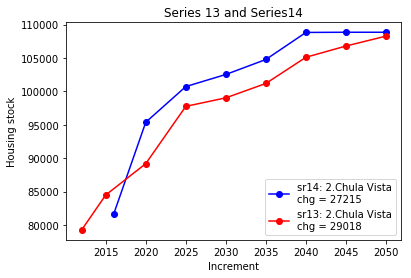

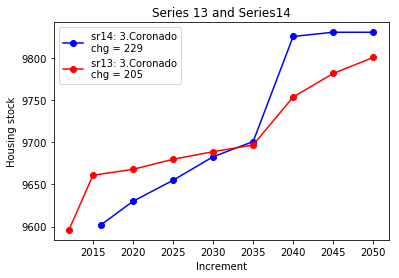

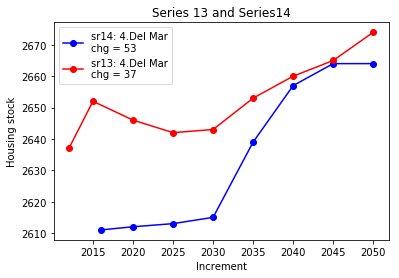

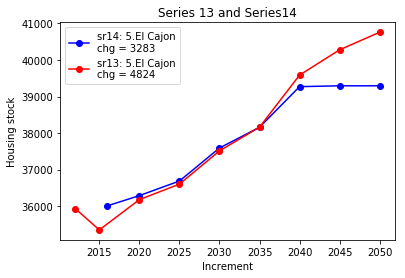

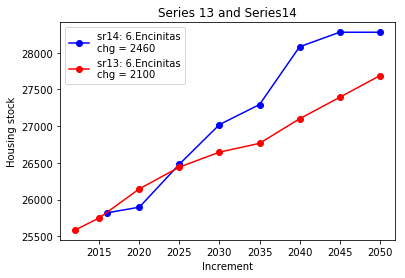

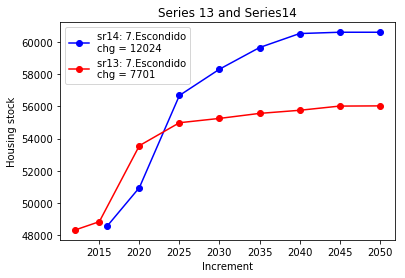

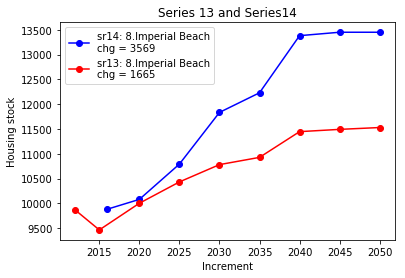

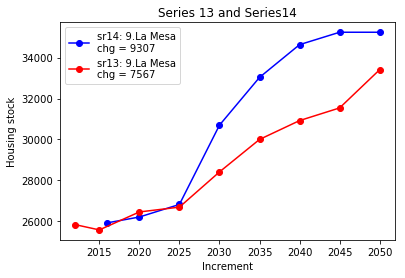

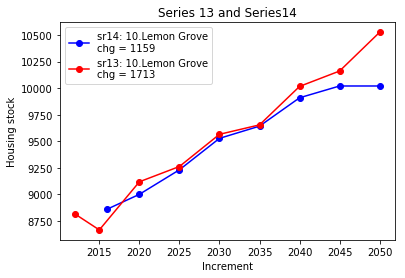

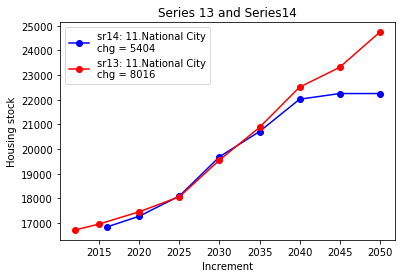

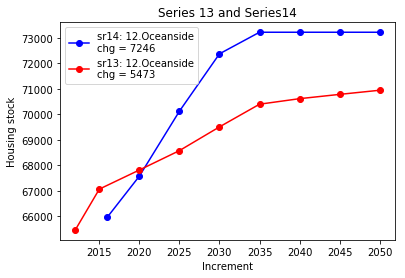

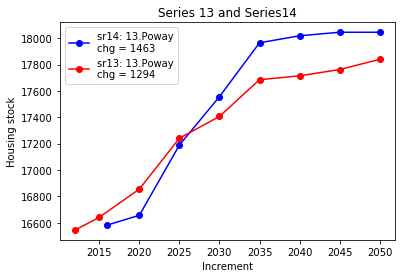

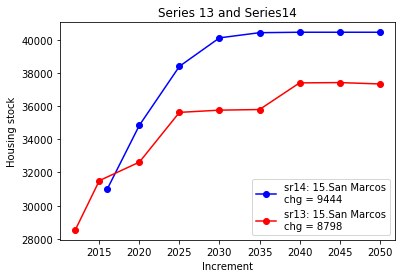

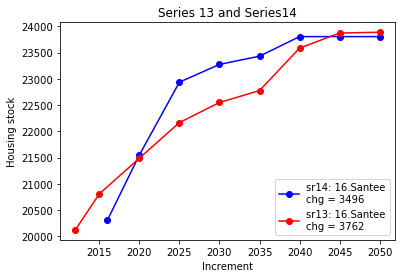

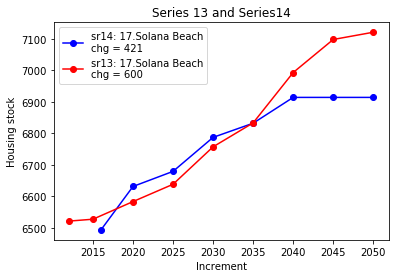

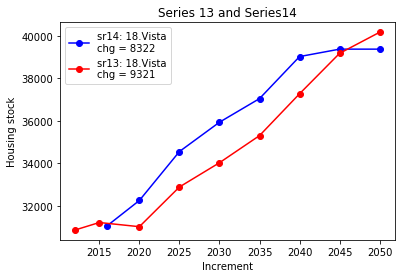

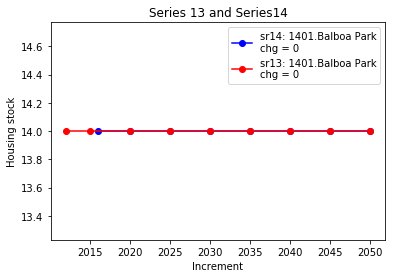

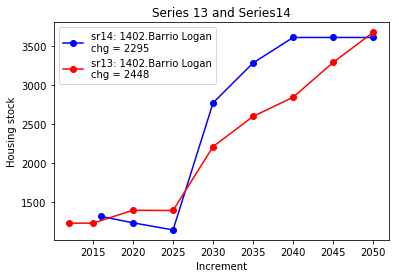

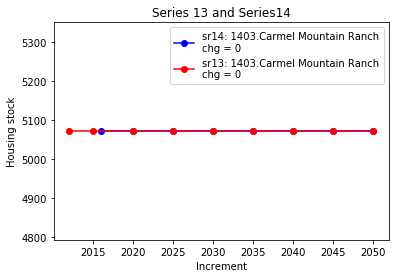

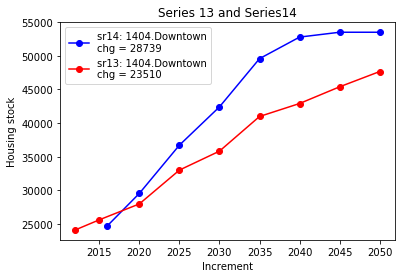

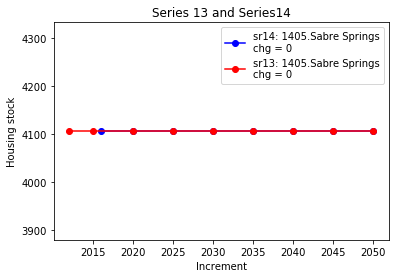

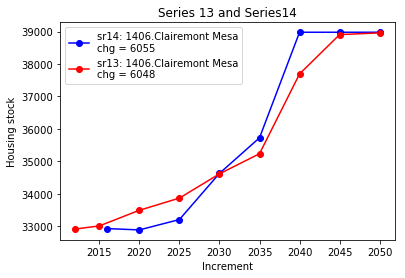

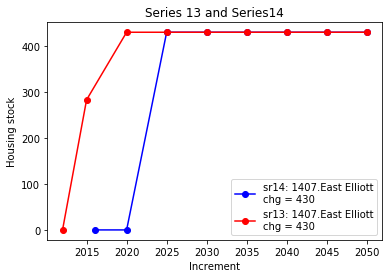

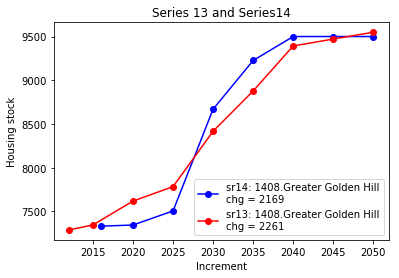

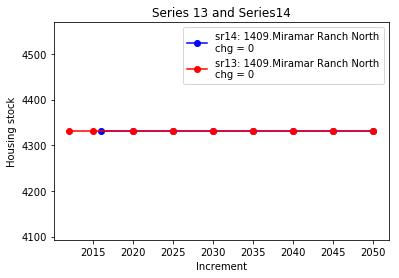

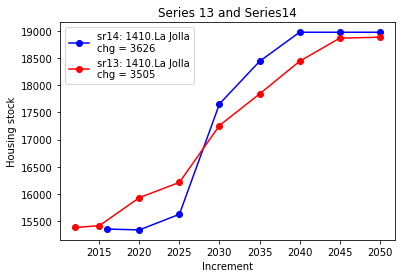

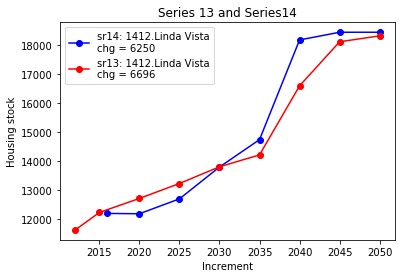

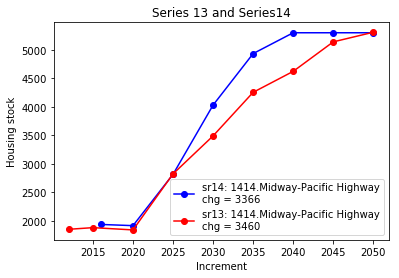

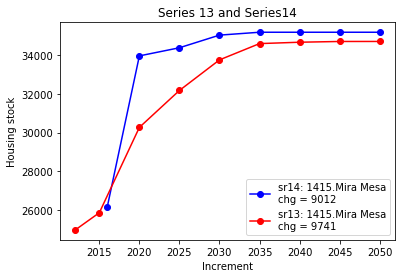

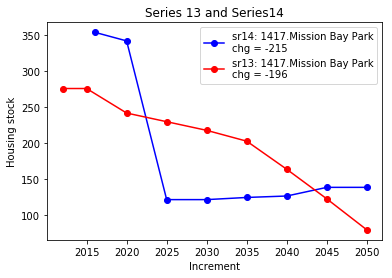

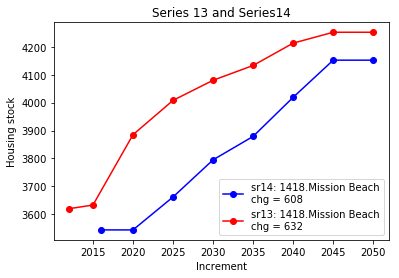

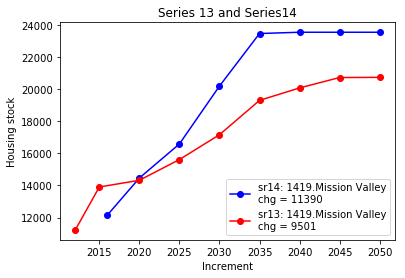

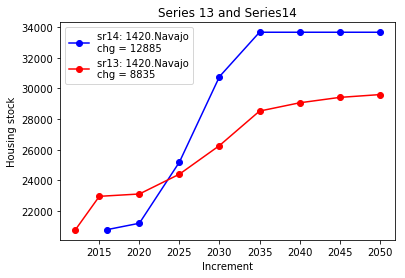

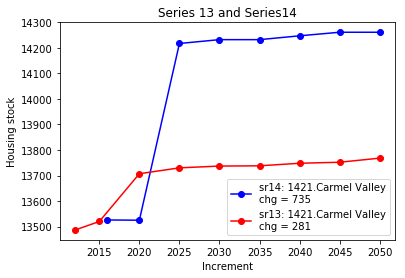

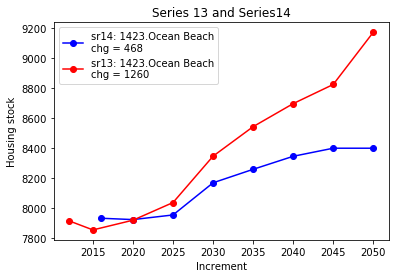

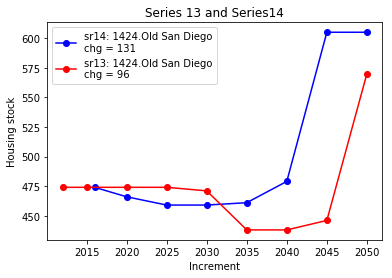

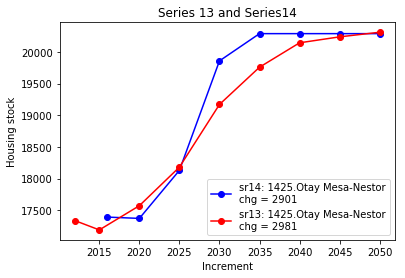

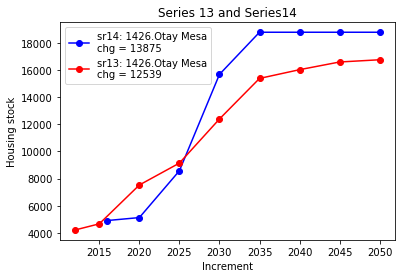

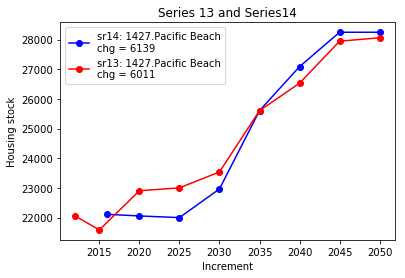

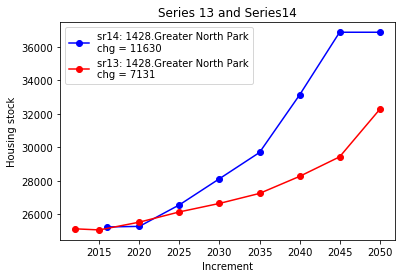

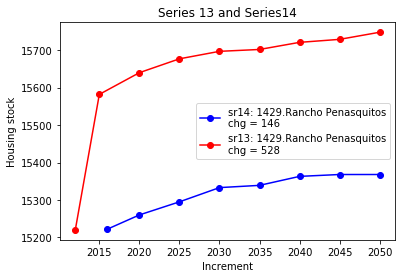

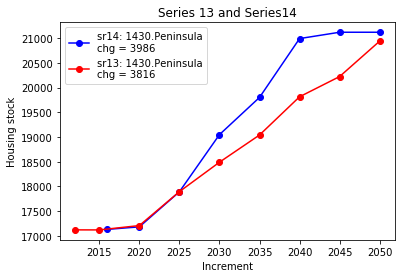

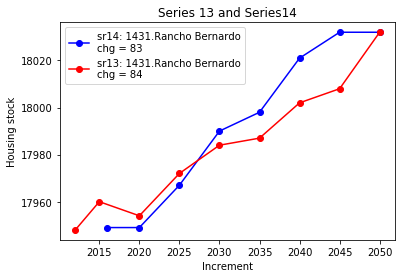

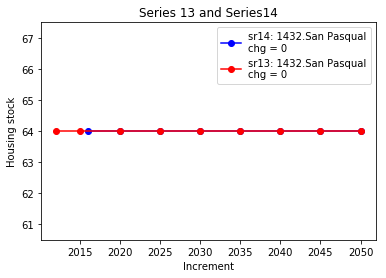

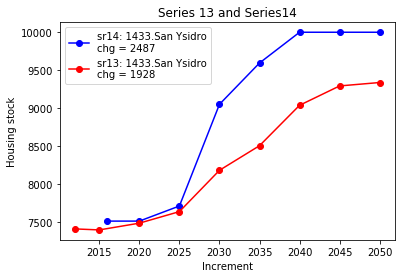

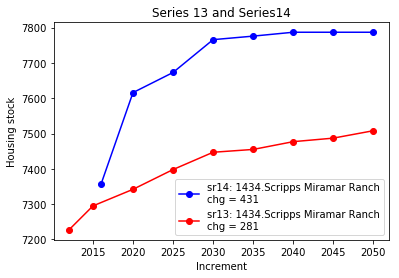

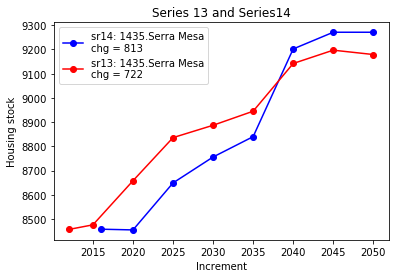

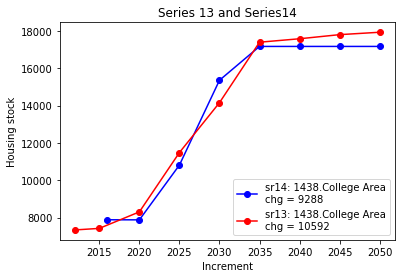

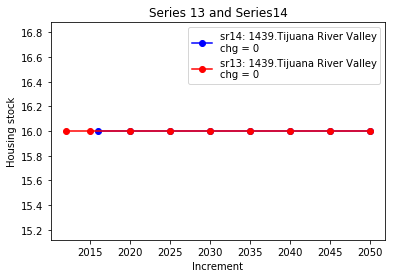

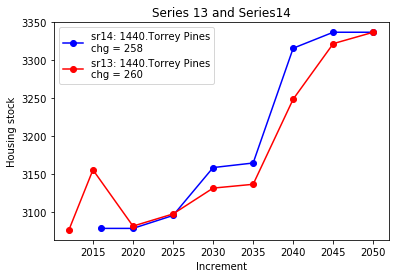

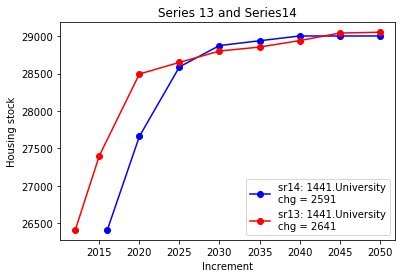

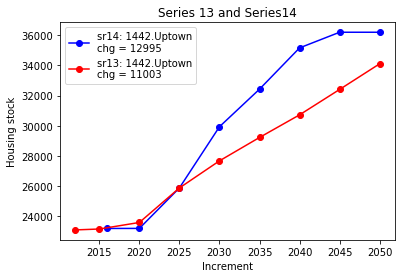

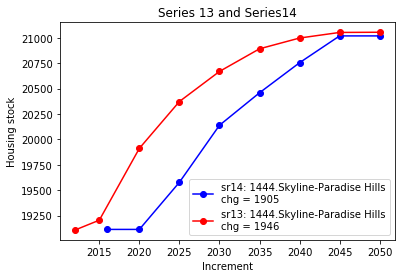

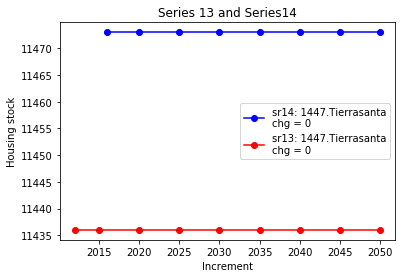

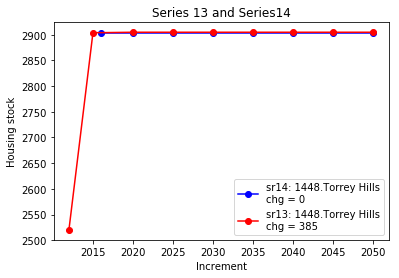

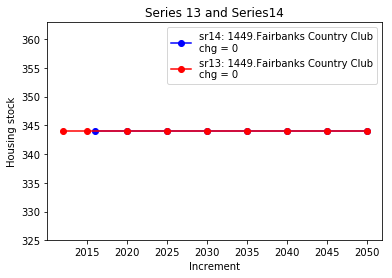

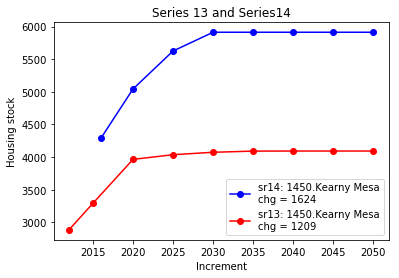

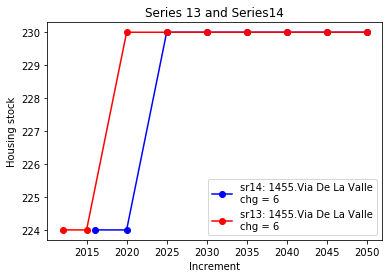

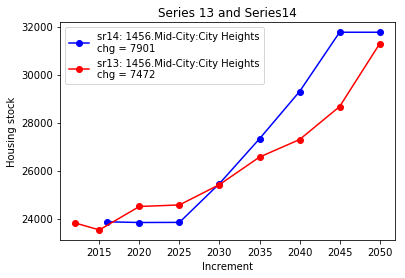

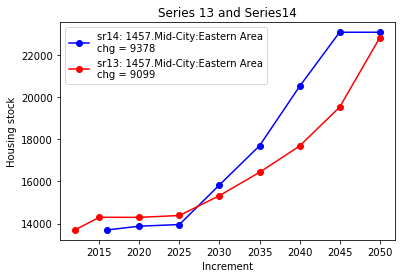

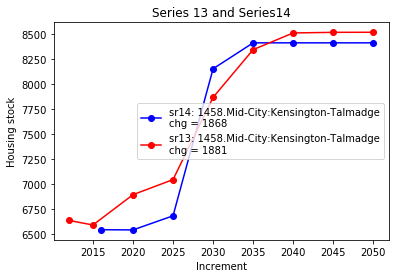

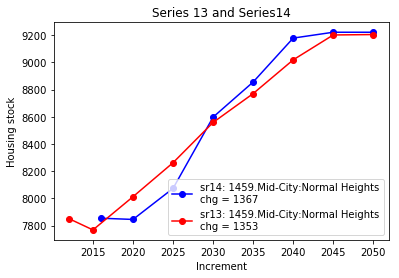

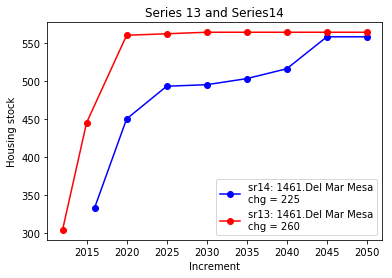

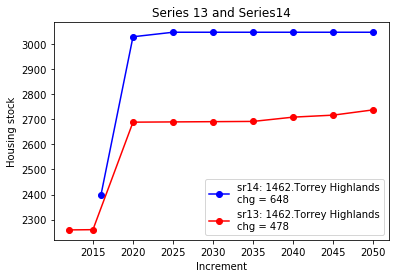

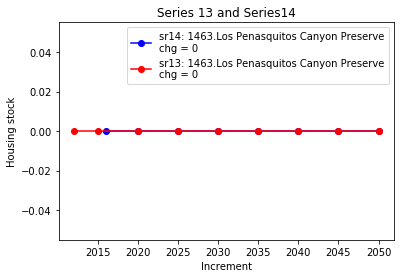

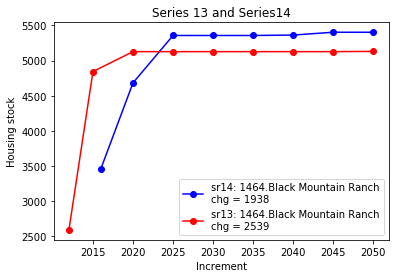

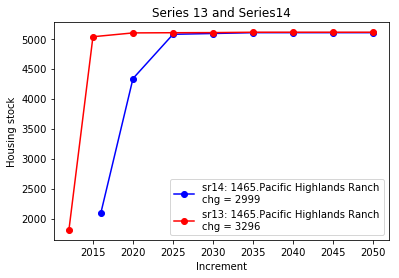

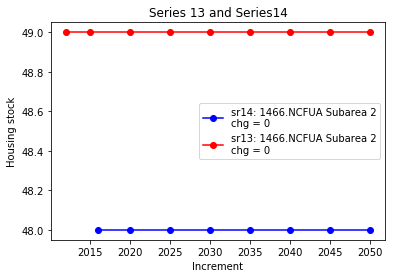

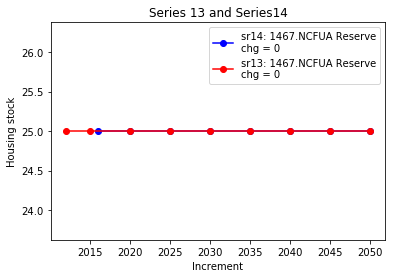

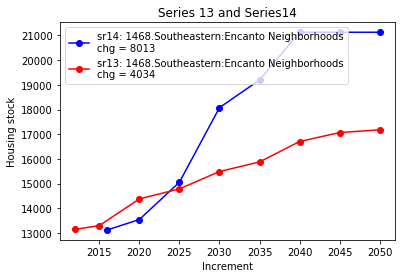

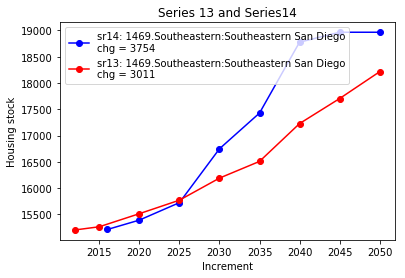

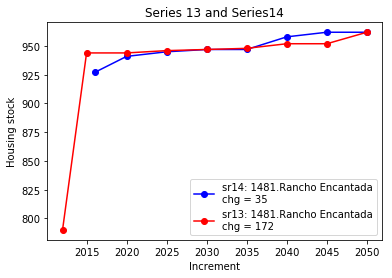

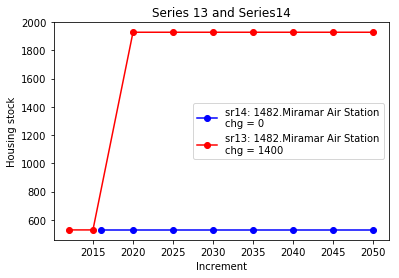

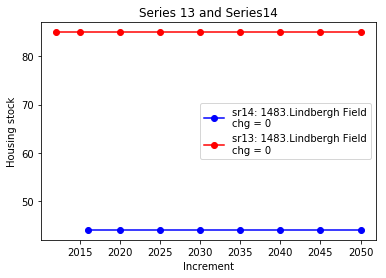

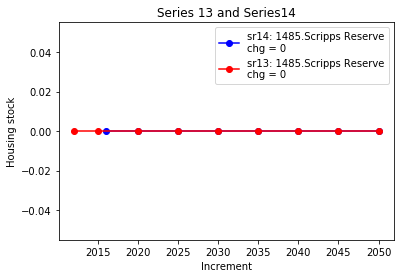

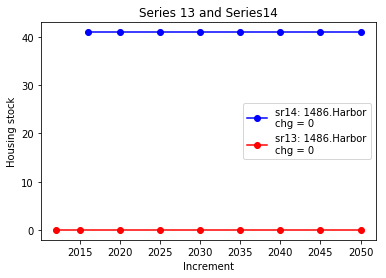

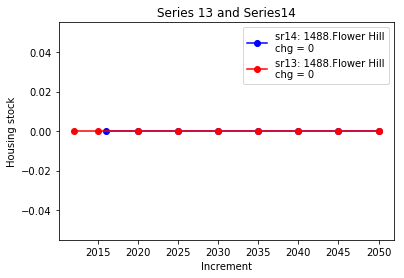

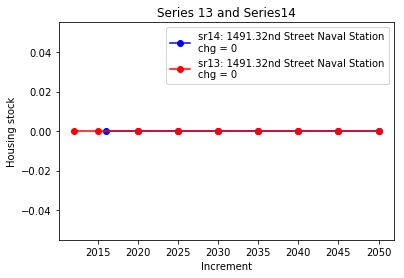

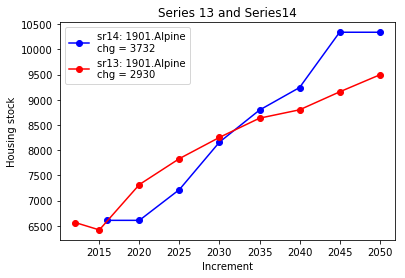

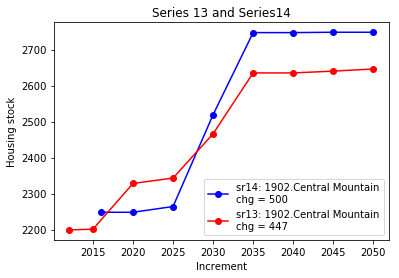

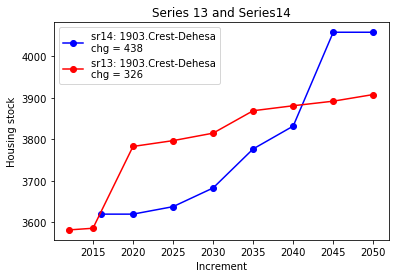

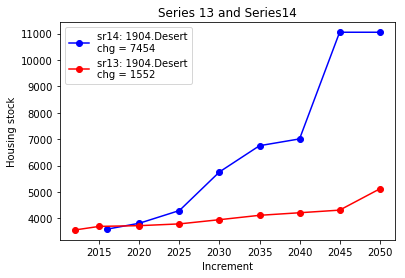

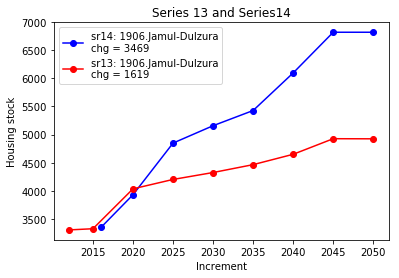

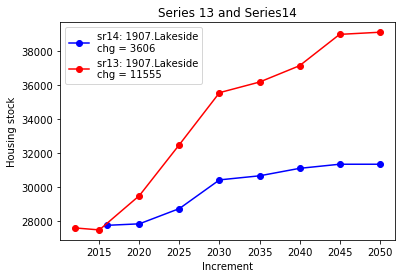

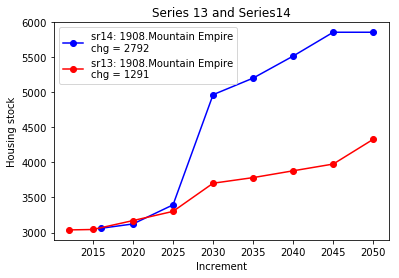

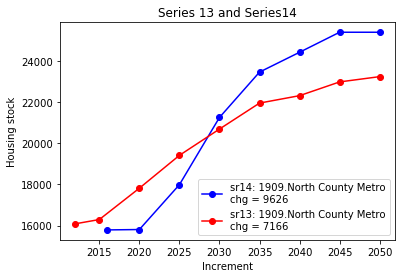

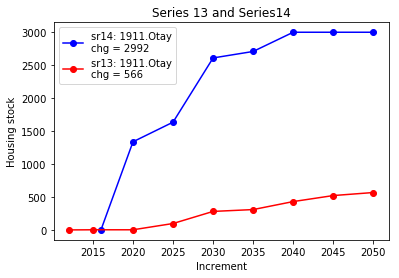

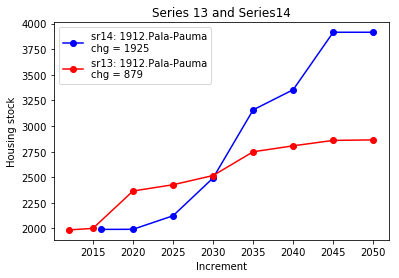

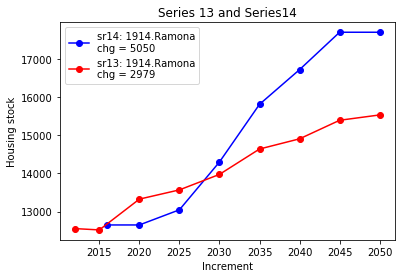

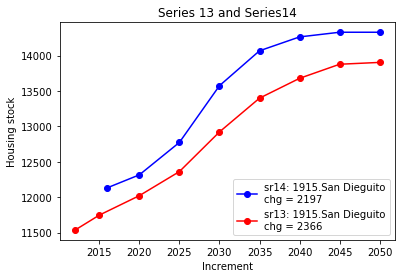

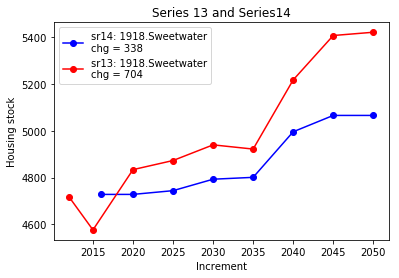

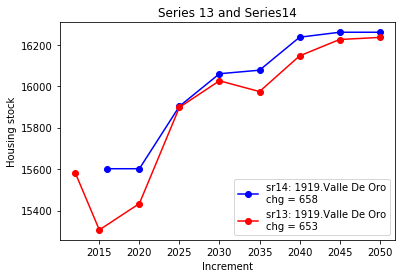

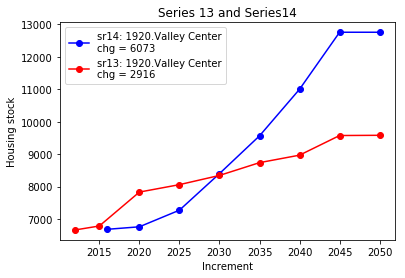

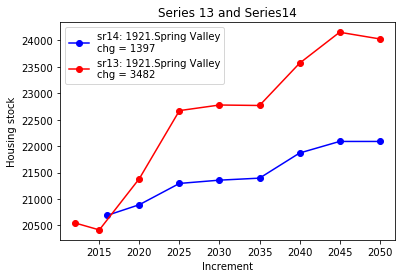

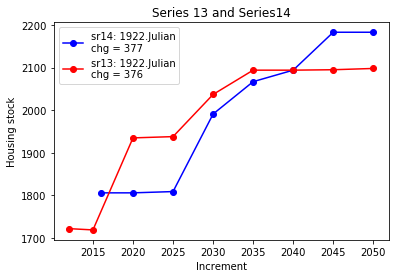

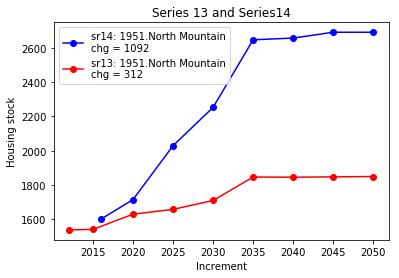

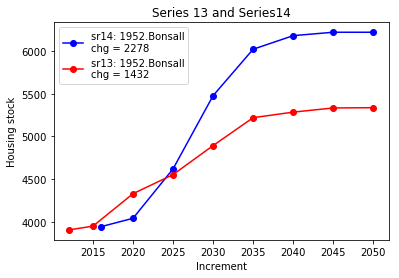

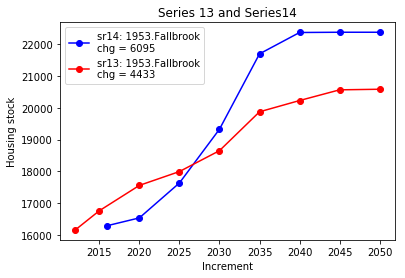

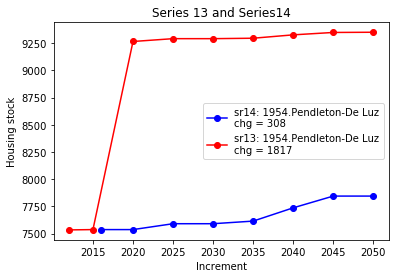

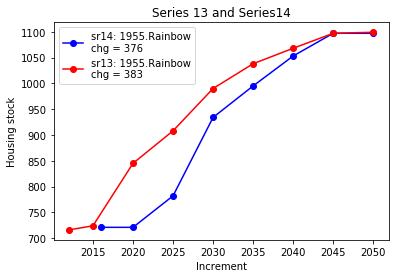

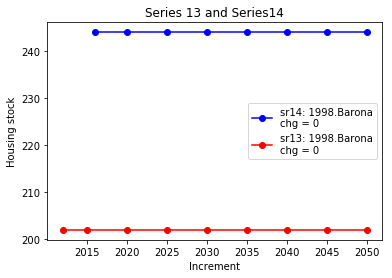

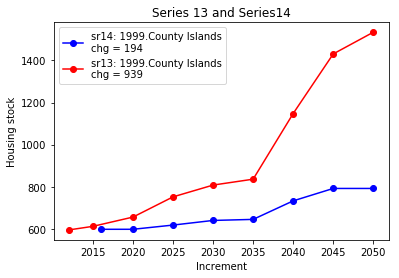

In [83]:
pp = PdfPages("jur_and_cpa_sr13_and_sr14.pdf")
for j, jur in enumerate(sr14_geo_df.geo.unique().tolist()):
# for j, jur in  enumerate(['Carlsbad','Chula Vista']):
    chg = int(sr14_increment.loc[(sr14_increment.increment=='2050') & (sr14_increment.geo==jur)].hs_cumulative)
    jur_and_cpa_plot = plt.figure()
    # plt.subplot(20, 1, j+1)
    # plotlabel = jur + '\nchg = ' + str(int(totalchange.loc[jur][0]))
    plotlabelsr14 = 'sr14: '+ str(sr14_geo_df.loc[sr14_geo_df['geo']==jur].index.values[0]) + '.' +\
                jur + '\nchg = ' + str(chg)
    plotlabelsr13 = 'sr13: ' + str(sr13_geo_df.loc[sr13_geo_df['geo']==jur].jur_or_cpa_id.values[0]) + '.' +\
                jur + '\nchg = ' + str(int(totalchange.loc[jur][0]))
    
    #plt.plot(sr14_geo_df_pivot[[jur]].reset_index().increment.tolist(),sr14_geo_df_pivot[[jur]].reset_index()[jur].tolist(),
            # label=plotlabelsr14,
    #         sr13_geo_df_pivot[[jur]].reset_index().increment.tolist(),sr13_geo_df_pivot[[jur]].reset_index()[jur].tolist(),
     #        label=plotlabelsr13
     #       )
    plt.plot(sr14_geo_df_pivot[[jur]].reset_index().increment.tolist(),
             sr14_geo_df_pivot[[jur]].reset_index()[jur].tolist(),'b-o', label=plotlabelsr14)
    plt.plot(sr13_geo_df_pivot[[jur]].reset_index().increment.tolist(),
             sr13_geo_df_pivot[[jur]].reset_index()[jur].tolist(),'r-o', label=plotlabelsr13)
    plt.legend()
    plt.ylabel('Housing stock')
    plt.xlabel('Increment')
    plt.title('Series 13 and Series14')
    pp.savefig(jur_and_cpa_plot, dpi = 300, transparent = True)
pp.close()
# plt.savefig('sr13_jur_and_cpa.png')